## Installation des librairie nécessaire

In [ ]:
#!pip install --upgrade pip 
#!pip3 install --upgrade numpy
#!pip install keras
#!pip install tensorflow

## Import des librairies

In [1]:
# Import des librairies AWS: S3, Sagemaker, PySpark
# S3
import boto3
import botocore.session

# Sagemaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
import sagemaker_pyspark

# Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.ml.feature #import PCA
from pyspark.sql.functions import size, col

In [2]:
import pandas as pd
import os
from PIL import Image, ImageOps, ImageFilter
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pickle
from io import StringIO
import cv2

## Initialisation de la session Spark

In [3]:
session = botocore.session.get_session()
credentials = session.get_credentials()

conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))

spark = (
    SparkSession
    .builder
    .config(conf=conf) \
    .config('fs.s3a.access.key', credentials.access_key) \
    .config('fs.s3a.secret.key', credentials.secret_key) \
    .config("spark.driver.memory", "15g") \
    .master('local[*]') \
    .appName("P8_opc") \
    .getOrCreate()
)

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/17 15:20:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import des données depuis notre bucket S3

In [4]:
bucket_name = 'p8-opc-train-aginth'

In [5]:
 # Récupération des ressources sur le service AWS S3
s3_client = boto3.client("s3")
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

In [6]:
# METHODE 1 AVEC SIFT

ls_features=dict()
for my_bucket_object in bucket.objects.all():
    if my_bucket_object.key.endswith('jpg'):
        file_byte_string = s3_client.get_object(Bucket=bucket_name, Key=my_bucket_object.key)['Body'].read()
        
        np_1d_array = np.frombuffer(file_byte_string, dtype="uint8")
        new_size = (20, 20)
        img = cv2.imdecode(np_1d_array, cv2.IMREAD_COLOR)
        resized = cv2.resize(img, new_size)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(resized, None)
        if str(type(descriptors)) != "<class 'NoneType'>":
            ls_features[my_bucket_object.key]= descriptors.tolist()[0]

In [7]:
len(ls_features)

5719

In [ ]:
# METHODE 2 AVEC FLATTEN

#ls_features=dict()
#for my_bucket_object in bucket.objects.all():
#    ls_features[my_bucket_object.key]=[]
#    if my_bucket_object.key.endswith('jpg'):
##        file_byte_string = s3_client.get_object(Bucket=bucket_name, Key=my_bucket_object.key)['Body'].read()
#        byte_image = BytesIO(file_byte_string)
#        
#        new_size = (20, 20)
#        img = load_img(byte_image,target_size=new_size,color_mode="rgb")
#    
#        # image en array 
#        img_array = img_to_array(img).flatten()
#
#        ls_features[my_bucket_object.key]=img_array.tolist()

## Création de la Dataframe PySpark

In [8]:
def features_pyspark_df(features_val,features_keys):

    features_df = spark.createDataFrame([(l,) for l in features_val], ['Features'])
    img_df = spark.createDataFrame([(l,) for l in features_keys], ['img_path'])
    
    img_df = img_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
    features_df = features_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

    df_img_feat = img_df.join(features_df, img_df.row_idx == features_df.row_idx).drop("row_idx")
    return df_img_feat

In [9]:
df_feat = features_pyspark_df(list(ls_features.values()),list(ls_features.keys()))

In [10]:
df_feat.show(2)

22/12/17 15:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:34:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/17 15:35:02 WARN TaskSetManager: Stage 1 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.


22/12/17 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+--------------------+--------------------+
|            img_path|            Features|
+--------------------+--------------------+
|Training/apple_6/...|[1.0, 2.0, 3.0, 4...|
|Training/apple_6/...|[4.0, 4.0, 1.0, 3...|
+--------------------+--------------------+
only showing top 2 rows



In [11]:
nb_composante = len(df_feat.select('Features').take(1)[0][0])
nb_composante

22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:04 WARN TaskSetManager: Stage 7 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 15:35:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:05 WARN WindowExec:

22/12/17 15:35:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


128

## PCA & Reduction de données

In [12]:
def display_pca_eboulis(pca):
    varexpl = pca.explainedVariance*100
        
    # Affichage de la variance cumulée
    plt.figure(figsize=(11,7))
    plt.bar(np.arange(len(varexpl))+1, varexpl)

    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
    plt.axhline(y=90, linestyle="--", color="green",linewidth=1)

    limit = 90
    valid_idx = np.where(cumSumVar >= limit)[0]
    min_plans = valid_idx[cumSumVar[valid_idx].argmin()]
    print('90% de la variance expliqué par', min_plans, "composantes")
    plt.axvline(x=min_plans, linestyle="--",color="green",linewidth=1)

    plt.xlabel("Nb de composante")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

    return min_plans

In [13]:
def PCA (df_feat,nb_composante):
    vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = df_feat.select('Features', vector_dense("Features").alias("features_vd"))
    
    # PCA
    pca_spark = pyspark.ml.feature.PCA(inputCol="features_vd", outputCol="features_pca", k=nb_composante)
    pca = pca_spark.fit(img_vd_df)
    min_plans = display_pca_eboulis(pca)
    
    pca_spark = pyspark.ml.feature.PCA(inputCol="features_vd", outputCol="features_pca", k=min_plans)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)
    
    return pca_matrix

22/12/17 15:35:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:18 WARN TaskSetManager: Stage 13 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 15:35:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:18 WARN WindowExec

22/12/17 15:35:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/17 15:35:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/12/17 15:35:29 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
90% de la variance expliqué par 40 composantes


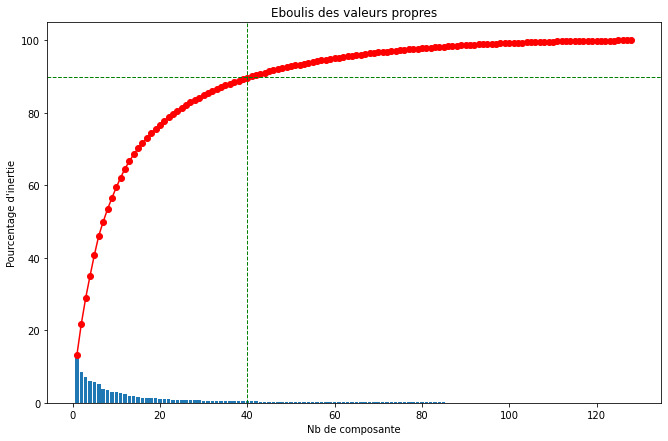

22/12/17 15:35:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:31 WARN TaskSetManager: Stage 27 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 15:35:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:32 WARN WindowExec

22/12/17 15:35:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [14]:
pca_matrix = PCA (df_feat,nb_composante)

In [15]:
df_feat = df_feat.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
pca_matrix = pca_matrix.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

pca_matrix = pca_matrix.join(df_feat, df_feat.row_idx == pca_matrix.row_idx).drop("row_idx")

In [16]:
pca_matrix = pca_matrix.drop("features_vd")
pca_matrix = pca_matrix.drop("Features")

In [17]:
pca_matrix.show(1)

22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 1

22/12/17 15:35:41 WARN TaskSetManager: Stage 43 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec

22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 1

22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+--------------------+--------------------+
|        features_pca|            img_path|
+--------------------+--------------------+
|[64.6104696738450...|Training/apple_6/...|
+--------------------+--------------------+
only showing top 1 row



## Export des données dans le bucket S3

In [18]:
#Sauvegarde du fichier :
s3_resource = boto3.resource('s3')
# Création d'un buffer 
csv_buffer = StringIO()
# Transformation dans un structure dataframe pandas
pca_matrix.toPandas().to_csv(csv_buffer)
# Ecriture du fichier csv dans le bucket s3
s3_resource.Object('p8-resultats', 'p8_result_with_pca.csv').put(Body=csv_buffer.getvalue())

22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 1

22/12/17 15:35:45 WARN TaskSetManager: Stage 58 contains a task of very large size (3478 KiB). The maximum recommended task size is 1000 KiB.
22/12/17 15:35:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:45 WARN WindowExec

22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 1

22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 15:35:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/17 1

{'ResponseMetadata': {'RequestId': '6JNAQ19348RS7BP0',
  'HostId': 'M8p+tVE3BPs3tkauBIt/GmXrTQgO8rp0mG2crLtZuOm/Ovfr6QVe60cRQ7a19xIG85aQxO/0O7s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'M8p+tVE3BPs3tkauBIt/GmXrTQgO8rp0mG2crLtZuOm/Ovfr6QVe60cRQ7a19xIG85aQxO/0O7s=',
   'x-amz-request-id': '6JNAQ19348RS7BP0',
   'date': 'Sat, 17 Dec 2022 15:35:50 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"da5e152b554f316718385260335d555b"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"da5e152b554f316718385260335d555b"',
 'ServerSideEncryption': 'AES256'}

## Arret Session Spark

In [19]:
spark.stop()